In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
plt.style.use('ggplot')

## Read and check the data

In [2]:
data = pd.read_csv('SC_Magpie_short_July2018.csv')
data.shape

(5000, 147)

In [3]:
X = data[data.columns[2:148]]
y = data["Tc"] #y = result["Tc"]

print(X.shape)
print(y.shape)
X.head()

(5000, 145)
(5000,)


,NComp,Comp_L2Norm,Comp_L3Norm,Comp_L5Norm,Comp_L7Norm,Comp_L10Norm,mean_Number,maxdiff_Number,dev_Number,max_Number,...,max_SpaceGroupNumber,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar
0,4,0.583781,0.506891,0.459606,0.441643,0.428710,30.360000,37,6.214400,56,...,229,166,197.5,0.198312,0.126582,0.675105,0.000000,0,0.370230,0.101293
1,5,0.606413,0.557901,0.543545,0.542136,0.541937,22.677795,49,16.074864,57,...,229,12,12.0,0.277798,0.340779,0.381423,0.000000,0,0.803211,0.321647
2,2,0.724017,0.659084,0.622509,0.613736,0.610693,43.220000,2,0.951600,44,...,229,194,194.0,0.138504,0.000000,0.861496,0.000000,0,0.000400,0.000190
3,3,0.700772,0.663969,0.655637,0.655203,0.655173,58.000000,26,10.482759,76,...,194,141,141.0,0.126638,0.082969,0.493450,0.296943,0,0.201983,0.036805
4,6,0.512258,0.435720,0.405168,0.400893,0.400075,36.658000,75,27.869600,83,...,225,12,70.0,0.187652,0.286921,0.187652,0.337774,0,0.866866,0.228340


## Create target for classification

Split the $T_c$'s into two bins - $T_c$ above/below some $T_{sep}$

How to choose $T_{sep}$? Let's use $T_{sep}=0$ for the moment.

In [5]:

from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_fscore_support

z = y.apply(lambda x: 1 if x > 10 else 0) 
X_train, X_test, z_train, z_test = train_test_split(X, z,  test_size=0.20,  random_state=41)
print(z.sum()/len(z))

#

0.3776


## Test simple model

Random forest without any optimization, apart from increasing the number of trees to 100 (default is 10).

In [6]:

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(oob_score = True, n_jobs = -1, n_estimators=100)
rfc.fit(X_train, z_train)

print(rfc.oob_score_, ",", rfc.score(X_test, z_test)) 
print(precision_recall_fscore_support(z_test, rfc.predict(X_test)))#f1_score(z_test, rfc.predict(X_test))

0.88325 , 0.9
(array([0.92948718, 0.85106383]), array([0.91194969, 0.87912088]), array([0.92063492, 0.86486486]), array([636, 364]))


In [7]:
print(rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


## Selecting $T_{sep}$

Let's try models with different $T_{sep}$

In [8]:
highTc_prop = []
score = []
pres_recall = []

Tsep = [1, 5, 10, 15, 20, 25, 30, 35, 40]

for T in Tsep:
    z = y.apply(lambda x: 1 if x > T else 0) 
    X_train, X_test, z_train, z_test = train_test_split(X, z,  test_size=0.2)
    highTc_prop.append(z.sum()/float(len(z)))
    rfc = RandomForestClassifier(n_estimators=300, oob_score = True, n_jobs = -1,random_state =20,
                           max_features = "sqrt", min_samples_split = 2)
    rfc.fit(X_train, z_train)
    score.append(rfc.oob_score_)
    pres_recall.append(precision_recall_fscore_support(z_test, rfc.predict(X_test)))
    print("Tc = {} K".format(T)) 
    print("accuracy:", rfc.oob_score_, ",",rfc.score(X_test, z_test)) 
    print(precision_recall_fscore_support(z_test, rfc.predict(X_test))) #f1_score(z_test, rfc.predict(X_test))


Tc = 1 K
accuracy: 0.8225 , 0.822
(array([0.7601626 , 0.84217507]), array([0.61111111, 0.91498559]), array([0.67753623, 0.87707182]), array([306, 694]))
Tc = 5 K
accuracy: 0.84775 , 0.859
(array([0.8802521 , 0.83969466]), array([0.83300199, 0.88531187]), array([0.85597549, 0.8619001 ]), array([503, 497]))
Tc = 10 K
accuracy: 0.88725 , 0.891
(array([0.91585761, 0.85078534]), array([0.90850722, 0.86206897]), array([0.91216761, 0.85638999]), array([623, 377]))
Tc = 15 K
accuracy: 0.903 , 0.905
(array([0.92477876, 0.86335404]), array([0.93442623, 0.8449848 ]), array([0.92957746, 0.85407066]), array([671, 329]))
Tc = 20 K
accuracy: 0.908 , 0.919
(array([0.94101877, 0.85433071]), array([0.94993234, 0.83141762]), array([0.94545455, 0.84271845]), array([739, 261]))
Tc = 25 K
accuracy: 0.918 , 0.923
(array([0.95532194, 0.82008368]), array([0.94415584, 0.85217391]), array([0.94970607, 0.8358209 ]), array([770, 230]))
Tc = 30 K
accuracy: 0.92775 , 0.913
(array([0.9523212 , 0.75862069]), array([0.

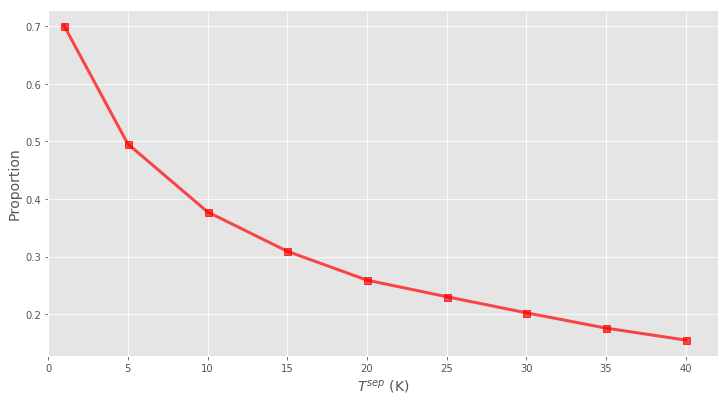

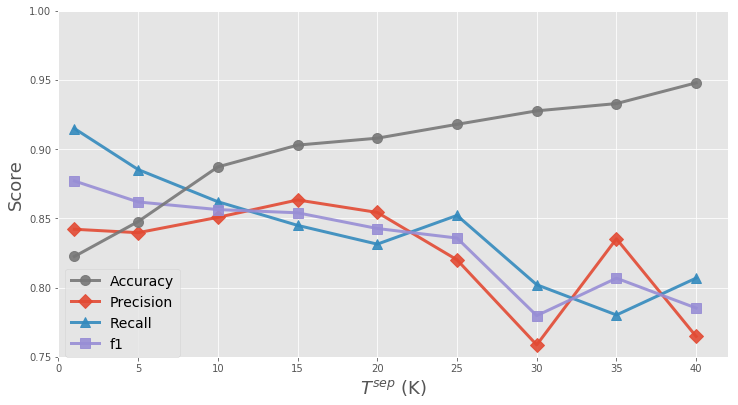

In [9]:
pres =[]
recall =[]
f1 =[]

for n in range(len(Tsep)):
    pres.append(pres_recall[n][0][1])
    recall.append(pres_recall[n][1][1])
    f1.append(pres_recall[n][2][1])
    
plt.rcParams['figure.figsize'] = (12.0, 14.0)

Tcutt = [1, 5, 10, 15, 20, 25, 30, 35, 40]
# line_prop, = plt.plot(Tsep, highTc_prop, 'sr--', ms = 8, alpha = 0.7, label='Proportion', linewidth = 2)

plt.subplot(211)
plt.plot(Tcutt, highTc_prop, 'sr-', ms = 7, alpha = 0.7, label='Proportion', linewidth = 3)
plt.xlim(0, 42)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel(r'$T^{sep}$ (K)', fontsize=14) 
plt.show()

plt.subplot(212)
line_pres, = plt.plot(Tsep, pres, 'D-', ms = 10, alpha = 0.9, label='Precision', linewidth = 3)
line_recall, = plt.plot(Tsep, recall, '^-', ms = 10, alpha = 0.9, label='Recall', linewidth = 3)
line_f1, = plt.plot(Tsep, f1, 's-', ms = 10, alpha = 0.9, label='f1', linewidth = 3)
line_accur, = plt.plot(Tsep, score, 'o-', ms = 10, alpha = 0.9, label='Accuracy', linewidth = 3)
plt.legend(handles=[ line_accur, line_pres, line_recall, line_f1], loc= (0.01, 0.0), fontsize=14)
#plt.plot(Tcutt, [0.86067131, 0.85939258, 0.8448,  0.84909457, 0.86597938 ], 'g-o', ms = 5, alpha = 0.7)
#plt.plot([1, 10, 20, 30, 40], [0.9556962 , 0.93512852, 0.89643463, 0.88469602,  0.896], 'y-o', ms = 5, alpha = 0.7)
plt.xlim(0, 42)
plt.ylim(0.75, 1.0)
plt.ylabel('Score', fontsize=18)
plt.xlabel(r'$T^{sep}$ (K)', fontsize=18)    
plt.show()


## Optimize the model

Use GridSearch to find better hyper-parameters

In [12]:
#from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestRegressor
#digits = load_boston()
#X, y = dataset.data, dataset.target

z = y.apply(lambda x: 1 if x > 10 else 0)

model = RandomForestClassifier(random_state=30)
param_grid = {"n_estimators"      : [100],
           #"criterion"         : ["gini", "entropy"],
           "max_features"      : [8,10, "sqrt", 14 ], #,
              'max_depth': [15, 20, 25],
            'min_samples_split':range(2, 11, 2)
         # "bootstrap": [True, False]
             }
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5)
grid_search.fit(X_train, z_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 20, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 100}
0.94825


In [13]:
rfc = RandomForestClassifier(oob_score = True, n_jobs = -1, n_estimators=500, 
                             min_samples_split = 2, max_features = 10 , max_depth = 20)
rfc.fit(X_train, z_train)

print(rfc.oob_score_, rfc.score(X_test, z_test), 
      precision_recall_fscore_support(z_test, rfc.predict(X_test)))#f1_score(z_test, rfc.predict(X_test))

0.9495 0.931 (array([0.9634434, 0.75     ]), array([0.95555556, 0.7862069 ]), array([0.95948326, 0.76767677]), array([855, 145]))


In [14]:
from sklearn.metrics import roc_auc_score
X_test_prob_pred = rfc.predict_proba(X_test)
roc_auc_score(z_test, X_test_prob_pred[:,1])

0.9719459568461383

## Size of the data set

Check how model performance changes with the size of the train set

In [15]:
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_estimators=100, oob_score = True, n_jobs = -1,random_state =20,
                           max_features = "sqrt", min_samples_split = 2)

score_size_train = []
f1_size_train = []
score_size = []
pres_recall_size = []
accur_size = []
X = data[data.columns[2:147]]
y = data["Tc"]
z = y.apply(lambda x: 1 if x > 10 else 0) #y = result["Tc"]
X_train, X_test, z_train, z_test = train_test_split(X, z,  test_size=0.2,  random_state=20)

z_train[:10]
sizes = range(100, 4000, 200)
X_train.iloc[:10, :].shape, z_train[:10].shape

for size in sizes:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]:
    data = data.reindex(np.random.permutation(data.index))
#     X_train, X_test, z_train, z_test = train_test_split(X.ix[:size, :], z,  test_size=0.15,  random_state=20)
#     highTc_prop.append(z.sum()/float(len(z)))
#     rfc = RandomForestClassifier(n_estimators=500, oob_score = True, n_jobs = -1,random_state =222)
    rfc = RandomForestClassifier(n_estimators=200, oob_score = True, n_jobs = -1,random_state =21,
                           max_features = "sqrt", min_samples_split = 3, max_depth = 16)
    rfc.fit(X_train.iloc[:size, :], z_train[:size])
    score_size.append(rfc.oob_score_)
    accur_size.append(rfc.score(X_test, z_test))
#     rfc_f1_size_train.append(f1_score(z_train, rfc.predict(X_train)))
    pres_recall_size.append(precision_recall_fscore_support(z_test, rfc.predict(X_test)))
    print(size, rfc.oob_score_)

100 0.77
300 0.7933333333333333
500 0.814
700 0.8157142857142857
900 0.8233333333333334
1100 0.8436363636363636
1300 0.8430769230769231
1500 0.8393333333333334
1700 0.85
1900 0.8557894736842105
2100 0.8552380952380952
2300 0.86
2500 0.8636
2700 0.8733333333333333
2900 0.8703448275862069
3100 0.8732258064516129
3300 0.8757575757575757
3500 0.8782857142857143
3700 0.8816216216216216
3900 0.8812820512820513


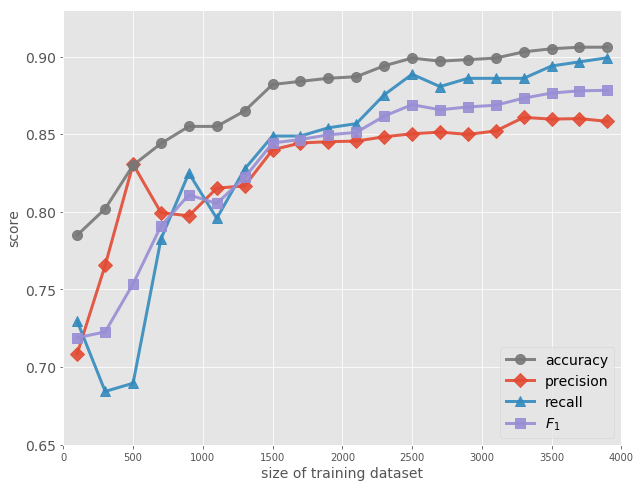

In [16]:
%matplotlib inline
f1_size =[]
pres_size =[]
recall_size =[]
for n in range(len(sizes)):
    f1_size.append(pres_recall_size[n][2][1])
    pres_size.append(pres_recall_size[n][0][1])
    recall_size.append(pres_recall_size[n][1][1])
    
# rfc_f1_size, rfc_pres_size, rfc_recall
plt.rcParams['figure.figsize'] = (10.0, 8.0)
ms=10
# line_accur, = plt.plot(sizes, rfc_score_size, 'b-o', ms = 7, alpha = 0.7, label='Accuracy')


line_pres, = plt.plot(sizes, pres_size, 'D-', ms = ms, alpha = 0.9, label='precision', linewidth = 3)
line_recall, = plt.plot(sizes, recall_size, '^-', ms = ms, alpha = 0.9, label='recall', linewidth = 3)
line_f1, = plt.plot(sizes, f1_size, 's-', ms = ms, alpha = 0.9, label=r'$F_{\mathrm{1}}$', linewidth = 3)
line_accur, = plt.plot(sizes, accur_size, 'o-', ms = ms, alpha = 0.9, label='accuracy', linewidth = 3)
plt.legend(handles=[ line_accur, line_pres, line_recall, line_f1], loc= 'lower right', fontsize=15)
plt.xlim(-0, 4000)
plt.ylim(0.65, 0.93)
plt.yticks(fontsize = 14)


plt.legend(handles=[ line_accur, line_pres, line_recall, line_f1], loc= 'lower right', fontsize=14)
plt.ylabel('score', fontsize=14)
plt.xlabel('size of training dataset', fontsize=14)

plt.show()

## Feature importances

Random forest provides feature importance measure (misleading if there are correlated features!).



In [17]:
print(rfc.feature_importances_)
importances = rfc.feature_importances_
print(importances.shape)

indexes = np.argsort(importances)[::-1]
for pred in indexes:
    print(X.columns[pred])

[7.21919898e-03 1.41883828e-02 1.18877785e-02 1.08683870e-02
 9.98642660e-03 9.35850273e-03 1.15900860e-02 4.02405865e-03
 1.13066906e-02 4.39653256e-03 2.30631680e-03 3.44362330e-03
 1.15031295e-02 2.94120635e-02 1.92513382e-02 4.02625734e-03
 6.75001795e-03 2.87042704e-03 1.18376887e-02 4.21969578e-03
 1.10016552e-02 3.72711715e-03 2.30470870e-03 6.34591482e-03
 1.36783829e-02 9.91060292e-03 1.59336912e-02 3.00431167e-03
 1.49295630e-02 7.82417139e-03 1.21093663e-02 2.20692993e-02
 2.13810781e-02 9.25370472e-04 1.24118514e-03 2.55305829e-03
 8.96495561e-03 1.40550133e-03 8.15048263e-03 1.44926885e-03
 7.30598214e-04 2.19326296e-03 1.11962909e-02 1.31379537e-02
 1.55232831e-02 3.01826683e-03 1.38159258e-02 5.37596168e-03
 1.19860080e-02 1.71687958e-02 2.82226452e-02 8.28946990e-03
 7.95610724e-03 6.47860051e-03 6.98319875e-03 5.00828854e-04
 7.74062466e-03 3.22636274e-05 5.61472496e-04 8.52913948e-04
 6.57349972e-03 1.34717746e-03 1.37785002e-02 2.99139538e-03
 8.33410111e-06 7.230003

[]

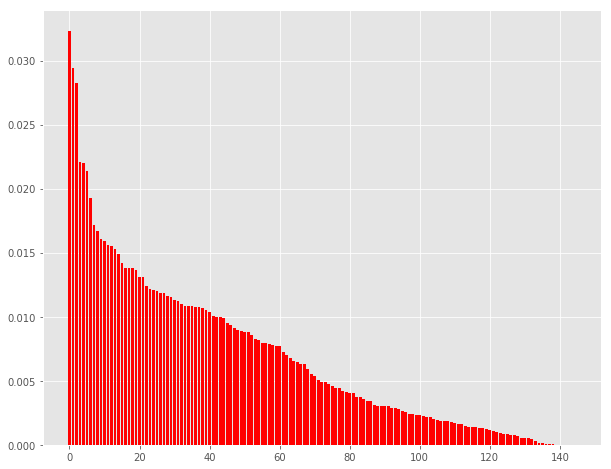

In [18]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.bar(range(X.shape[1]),importances[indexes] ,
       color="r")
plt.plot()

## Remove strongly correlated predictors

In [19]:
preds = X.columns[::-1]

print(preds.shape)

for pred in preds:
    t = X.corr()[pred][abs(X.corr()[pred])>0.90].index
    if t.size==0:
        preds = [p for p in preds if p!=pred]   
    else:
        preds = [p for p in preds if p not in t]   
        preds.append(pred)

print(len(preds))
#preds[::-1] 

(145,)
94


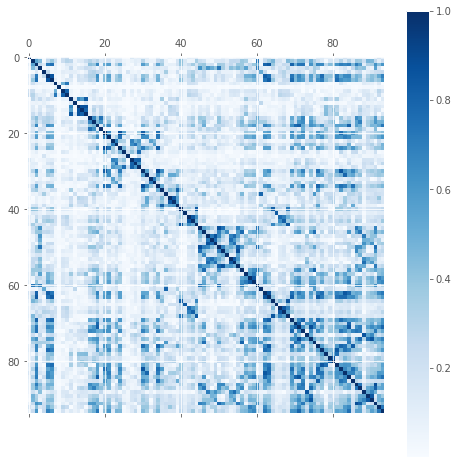

In [20]:
feature_corr = data[preds].corr().abs()
from matplotlib import cm as cm
cmap = cm.get_cmap("Blues")
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.matshow(feature_corr, cmap=cmap)
plt.colorbar()
plt.show()

In [21]:
rfc_reduced = RandomForestClassifier(oob_score = True, n_jobs = -1, n_estimators=500, min_samples_split = 2 )
rfc_reduced.fit(X_train[preds], z_train)

print(rfc_reduced.oob_score_, rfc_reduced.score(X_test[preds], z_test), 
      precision_recall_fscore_support(z_test, rfc_reduced.predict(X_test[preds])))#f1_score(z_test, rfc.predict(X_test))

0.88325 0.907 (array([0.93300654, 0.86597938]), array([0.91653291, 0.89124668]), array([0.92469636, 0.87843137]), array([623, 377]))


In [22]:

importances_reduced = rfc_reduced.feature_importances_
print(importances_reduced.shape)

indexes_reduced = np.argsort(importances_reduced)[::-1]
for pred in indexes_reduced:
    print(X[preds].columns[pred])



(94,)
maxdiff_MendeleevNumber
maxdiff_GSvolume_pa
mean_Electronegativity
Comp_L2Norm
mean_Number
mean_NUnfilled
mean_CovalentRadius
min_MeltingT
NComp
dev_MeltingT
maxdiff_NdValence
dev_NUnfilled
mean_MeltingT
mean_MendeleevNumber
frac_pValence
maxdiff_CovalentRadius
frac_sValence
mean_GSvolume_pa
mean_Column
maxdiff_MeltingT
dev_NdValence
dev_NdUnfilled
dev_Number
maxdiff_SpaceGroupNumber
mean_NValance
frac_dValence
mean_SpaceGroupNumber
dev_NValance
mean_NdValence
dev_NpUnfilled
mean_NpUnfilled
mean_NdUnfilled
mean_NsUnfilled
mean_NpValence
most_Number
dev_NsUnfilled
dev_NsValence
mean_NsValence
maxdiff_NpValence
min_GSvolume_pa
min_NValance
mean_GSmagmom
max_MendeleevNumber
max_SpaceGroupNumber
min_Column
most_GSvolume_pa
maxdiff_Number
max_Number
dev_GSbandgap
mean_GSbandgap
mean_NfValence
most_MendeleevNumber
dev_NfValence
dev_NfUnfilled
mean_NfUnfilled
max_CovalentRadius
max_MeltingT
min_Number
maxdiff_GSmagmom
maxdiff_NValance
maxdiff_NUnfilled
max_NdValence
max_NValance
min_NUn

[]

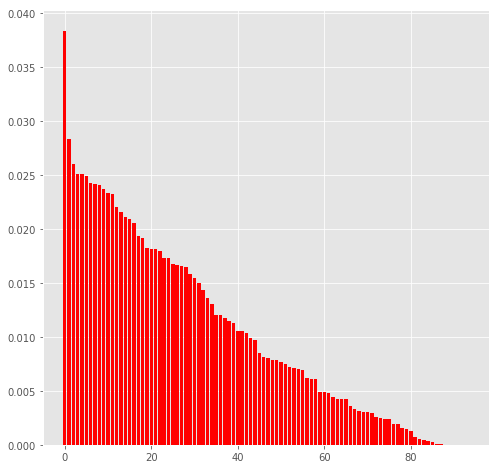

In [23]:
plt.bar(range(X[preds].shape[1]),importances_reduced[indexes_reduced] ,
       color="r")
plt.plot()

## Select the most important predictors*

In [35]:
z = y.apply(lambda x: 1 if x > 10 else 0)
rfc = RandomForestClassifier(n_estimators=500, oob_score = True, n_jobs = -1,random_state =222)

rfc_score_num_features = []
num_features = range(1, 145, 1) #range(1, 136, 1)#range(2, 102, 5) #range(83, 102, 1) #range(83, 108, 1)
indx_temp = X.columns# preds#


rfc.fit(X[indx_temp], z)
accur_init = rfc.oob_score_
print(accur_init)

for nf in  num_features:   
    rfc.fit(X[indx_temp], z)
    print(nf, rfc.oob_score_)
    if rfc.oob_score_ < accur_init*0.98:
            print("Break, number of predictors: {}".format(145-nf))
            print(rfc.oob_score_)
            break
    rfc_score_num_features.append(rfc.oob_score_)
    importances = rfc.feature_importances_
    indices = np.argsort(importances)[::-1]
    indx_temp = X[indx_temp].columns[indices][:145-nf]
    ind_imp = rfc.feature_importances_
    
rfc_score_num_features
rfc.fit(X[indx_temp], z)
ind_imp = rfc.feature_importances_
print(ind_imp)

0.8962
1 0.8962
2 0.8942
3 0.8964
4 0.8958
5 0.899
6 0.8968
7 0.8986
8 0.8964
9 0.8944
10 0.897
11 0.8954
12 0.8962
13 0.8966
14 0.895
15 0.8952
16 0.8954
17 0.897
18 0.8966
19 0.897
20 0.8964
21 0.896
22 0.8952
23 0.8974
24 0.8942
25 0.8984
26 0.8968
27 0.8946
28 0.8938
29 0.897
30 0.897
31 0.894
32 0.8968
33 0.8954
34 0.8958
35 0.8982
36 0.896
37 0.8972
38 0.8938
39 0.8982
40 0.8966
41 0.9004
42 0.8952
43 0.8948
44 0.8962
45 0.8962
46 0.8968
47 0.8952
48 0.8976
49 0.8962
50 0.895
51 0.8966
52 0.8972
53 0.8968
54 0.8976
55 0.8978
56 0.8966
57 0.897
58 0.8964
59 0.8968
60 0.8966
61 0.8972
62 0.8944
63 0.898
64 0.8968
65 0.8958
66 0.8958
67 0.8982
68 0.8948
69 0.8958
70 0.8958
71 0.8964
72 0.8962
73 0.8976
74 0.8966
75 0.8954
76 0.8984
77 0.8966
78 0.897
79 0.8984
80 0.8972
81 0.8986
82 0.8978
83 0.8972
84 0.8972
85 0.8974
86 0.895
87 0.8978
88 0.8986
89 0.8976
90 0.8962
91 0.8964
92 0.8986
93 0.897
94 0.8968
95 0.896
96 0.897
97 0.8962
98 0.8962
99 0.8972
100 0.8972
101 0.8958
102 0.89